In [17]:
import numpy as np
from sklearn import model_selection, datasets, metrics, neighbors
from sklearn import preprocessing

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [18]:
# установка рекомендуемых параметров для графиков
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

### Классификация сорта винограда с помощью kNN

Построим модель для классификации сорта винограда, из которого сделано вино. Для этого используем данные химических исследований, которые находятся в открытом доступе: [Wine data](https://archive.ics.uci.edu/ml/machine-learning-databases/wine)

**Загрузка данных**

In [19]:
columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',  
           'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
           'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
wine_df = pd.read_csv('wine.data', header = None, names = columns)
wine_df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Описание алгоритма**

Согласно описанию данных, всего в датасете находятся описания вин 3 сортов. Одним из методов решения задачи классификации является метод $k$ ближайших соседей.

Разбив данные на обучающую и тестовую выборки, получим, для каждого элемента из тестовой будем смотреть, к какому классу будут принадлежать его ближайшие $k$ соседей из обучающей выборки. Среди этого набора классов выберем тот, который встречается чаще всего среди этих $k$

Ближайшие соседи выбираются согласно некоторой метрике, которая является гиперпараметром модели. Приведём метрики, которые будут использованы, а также формулу для их вычисления по двум векторам из пространства $\mathbb{R}^n$

* Евклидово расстояние $\rho(x, y) = \sqrt{\sum\limits_{i = 1}^n (x_i - y_i)^2}$

* Манхэттенское расстояние $\rho(x, y) = \sum\limits_{i = 1}^n |x_i - y_i|$

* Метрика Чебышёва $\rho(x, y) = \max\limits_{i = 1}^n |x_i - y_i|$

Ещё одним гиперпараметром является количество соседей, которое просматривается. Попробуем исследовать, как изменится качество модели, если варьировать гиперпараметры.

Для оценки качества будем использовать метрику `accuracy`, которая равна доле правильных ответов на тестовой выборке. Конечной целью будет максимизация этой метрики.

Более того, для применяемой модели очень важен порядок величины различных признаков. Если признаки не отнормировать, то вклад одинаковых в процентном соотношении отклонений величины параметров в расстояние между точками будет разным.

**Разделение и нормализация данных данных**

In [20]:
# Исключение и сохраенние столбца с ответами, перевод в матричный вид
data = wine_df.drop('Class', axis = 1).values
labels = wine_df['Class'].values

In [21]:
# Разбиение на обучающую и тестовую выборки
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    data, 
    labels, 
    test_size = 0.3,
    random_state = 1
)

# Отнормируем данные
scaler = preprocessing.StandardScaler().fit(train_data)
test_data = scaler.transform(test_data)
train_data = scaler.transform(train_data)

**Вычисление ошибок**

In [22]:
r"""Вычисление метрики accuracy для kNN.

    Обучает kNN-классификатор с заданными параметрами на заранее фиксированной
    обучающей выборке. Предсказывает ответы для тестовой, считает долю верных.

    Parameters
    ----------
    metric : string
        Название метрики, по которой осуществляет поиск kNN.
        Возможные варианты можно найти в документации sklearn
    k : int
        Количество рассматриваемых соседей в kNN.
    
    Returns
    -------
    Значение метрики accuracy при заданных параметрах
    """
def get_knn_accuracy(k, metric):
    classifier = neighbors.KNeighborsClassifier(n_neighbors = k, metric = metric)
    classifier.fit(train_data, train_labels)
    y_pred = classifier.predict(test_data)
    return metrics.accuracy_score(test_labels, y_pred)

def plot_errors_by_k(metric, color = 'red', need_summary = True):
    r"""Построение зависимости доли правильных ответов от числа соседей.

    Обучает kNN с различным количеством соседей (от 2х до размера тестовой выборки)
    с использованием метрики `metric`, а затем строит график найденной зависимости.
    При желании выводит оптимальные параметры, максимизирующие качество.

    Parameters
    ----------
    metric : string
        Название метрики, по которой осуществляет поиск kNN.
        Возможные варианты можно найти в документации sklearn
    color : int
        Цвет, которым будет нарисован график.
    need_summary : 
        Если установлено значение True, то будут выведены параметры,
        при которых качество оптимально, а так же значение этого качества.
        По умолчанию True.
    """
    # Векторизация функции вычисления accuracy, чтобы она могла работать
    # c аргументами типа numpy.ndarray
    vectorized_accuracy_checker = \
        np.vectorize(lambda k: get_knn_accuracy(k, metric), signature = '()->()')
    k_grid = range(2, train_labels.size)
    res_accuracy = vectorized_accuracy_checker(k_grid)
    
    # Вычисление и вывод оптимальных параметров
    if need_summary:
        print('Maximum accuracy for {} metrics is {} reached with k = {}'.format(
            metric,
            np.max(res_accuracy),
            k_grid[np.argmax(res_accuracy)]))
    
    # Отрисовка графика
    plt.plot(k_grid, res_accuracy, color = color, label = metric, lw = 2)

**Построение графиков**

Maximum accuracy for euclidean metrics is 0.9814814814814815 reached with k = 3
Maximum accuracy for manhattan metrics is 0.9814814814814815 reached with k = 2
Maximum accuracy for chebyshev metrics is 0.9629629629629629 reached with k = 8


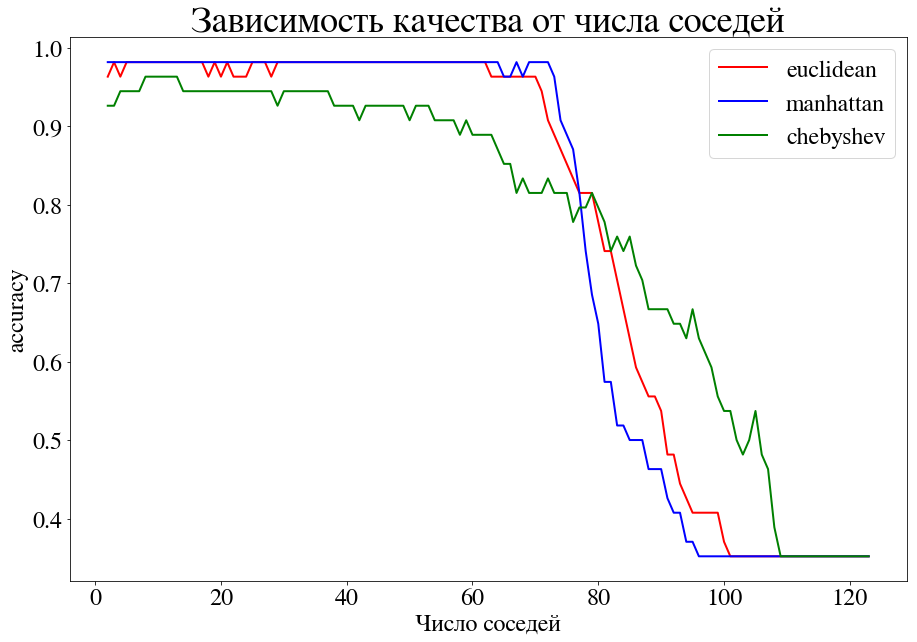

In [23]:
plt.figure(figsize=(15, 10))
plt.title('Зависимость качества от числа соседей')
plt.xlabel('Число соседей')
plt.ylabel('accuracy')

plot_errors_by_k('euclidean')
plot_errors_by_k('manhattan', color = 'blue')
plot_errors_by_k('chebyshev', color = 'green')

plt.legend()
plt.savefig('fig.eps')
plt.savefig('fig.png')
plt.show()

**Вывод**

Построенные модели показывают, что в целом качество модели ведёт себя одинаково при увеличении количества рассматриваемых соседей. Оптимальные значения наблюдаются при $k \leqslant 60$, затем качество начинает падать примерно линейно, и  начиная примерно с рассмотрения 100 соседей модель ведёт себя уже не лучше случайного предсказания (а точнее вырождается в константное предсказание наиболее объёмного класса)

На начальных значениях стабильнее всего и лучше ведёт себя модель, использующая манхэттенское расстояние. Использование расстояния Чебышёва оказывается хуже, однако такая модель точнее предсказывает класс при большом количестве соседей.

Видим, что лучшее значение качества достигается при использовании манхэттеновского расстояния при $k = 8$ и равно примерно $0.98$.

Интересно, что такой же эксперимент, проведённый без нормализации данных, даёт точность предсказаний не выше $0.8$ на всех трёх рассмотренных метриках